In [1]:
import warnings
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

from modules.plotting_scripts import plot_surprisals, plot_all_in_one, get_avg_df, plot_avg_pos_neg

warnings.filterwarnings(action='ignore', category=RuntimeWarning)

### Surprisals Analysis

In [2]:
wikitext_surprisals = '../results/shuffled_bert_surprisals.txt'
surprisals = pd.read_csv(wikitext_surprisals, delimiter='\t')

In [4]:
print(f"Number of unique tokens: {surprisals['Token'].nunique()}")

Number of unique tokens: 9078


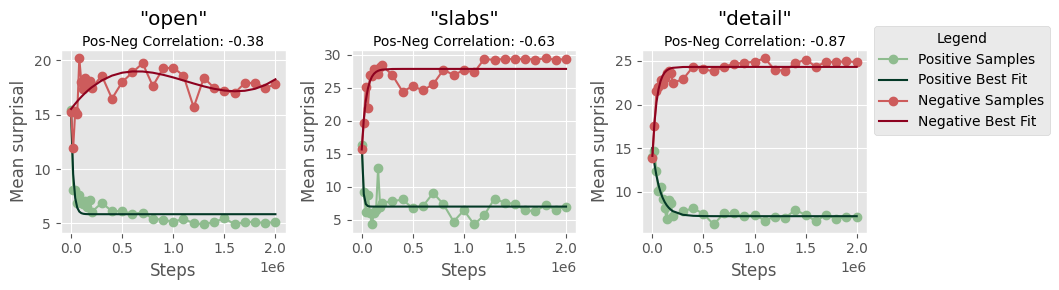

In [5]:
# good examples: 'ladder', 'composite', 'signaled', 'continual', 'depressed', 'snatch'
random_1 = random.choice(surprisals['Token'].unique().tolist())
random_2 = random.choice(surprisals['Token'].unique().tolist())
random_3 = random.choice(surprisals['Token'].unique().tolist())
plot_surprisals([random_1, random_2, random_3], surprisals, neg_samples=True, fit_curve=True)

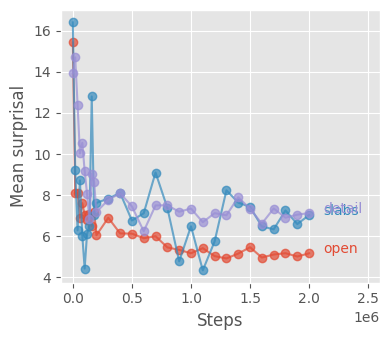

In [6]:
plot_all_in_one([random_1, random_2, random_3], surprisals)

In [7]:
# Tokens that haven't converged (the final surprisal is equal to or higher than the initial surprisal)
not_converged = surprisals.groupby('Token')\
                         .agg(first_surprisal=('MeanSurprisal', 'first'), 
                              last_surprisal=('MeanSurprisal', 'last'))\
                         .reset_index()\
                         .assign(overall_surprisal_diff=lambda x: x['last_surprisal'] - x['first_surprisal'])\
                         .query('overall_surprisal_diff >= 0')\
                         .reset_index(drop=True)
not_converged

,Token,first_surprisal,last_surprisal,overall_surprisal_diff
0,agenda,14.385452,14.530394,0.144941
1,arguably,15.969370,18.546284,2.576914
2,automobiles,13.881344,14.232363,0.351019
3,banging,15.381359,18.985399,3.604040
4,blended,14.523825,18.864544,4.340719
...,...,...,...,...
137,variable,15.045434,18.539169,3.493735
138,vera,14.920692,20.673443,5.752750
139,wharf,14.530179,18.905180,4.375001
140,wired,16.231590,22.428404,6.196814


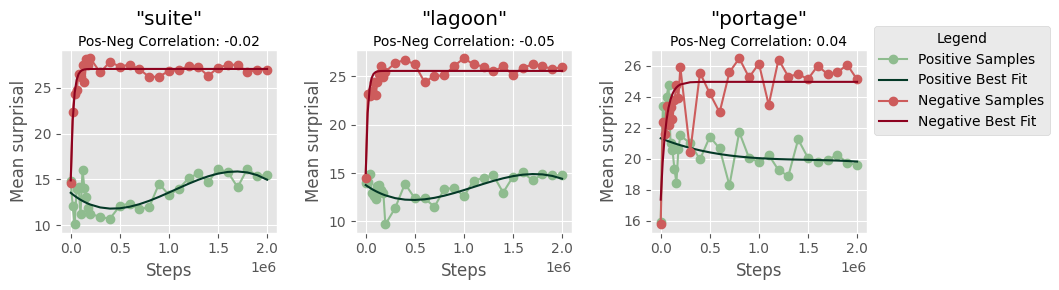

In [8]:
samples = not_converged.Token.sample(3).tolist()    # 'runaway', 'lightweight'
plot_surprisals(samples, surprisals, neg_samples=True, fit_curve=True)

### Most vs least frequent words

Percentage of frequent words in the dataset (occuring at least 512 times): 0.26%
Percentage of infrequent words in the dataset (occuring only once): 26.55%


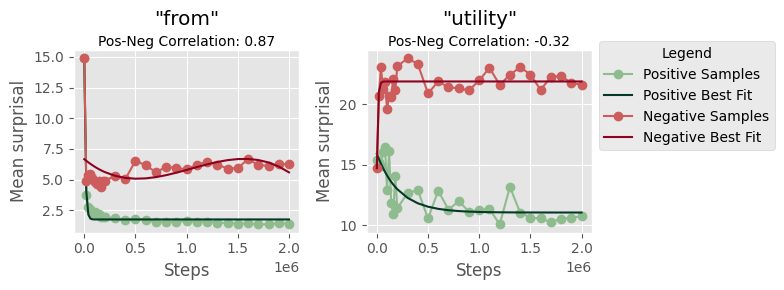

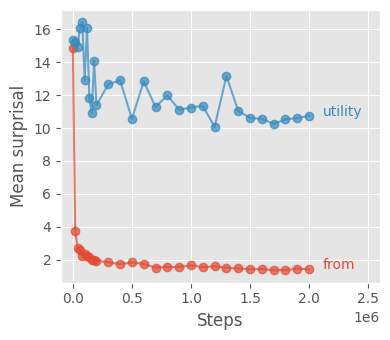

In [9]:
frequent = surprisals[surprisals['NumExamples'] == 512]
infrequent = surprisals[surprisals['NumExamples'] == 1]

print(f'Percentage of frequent words in the dataset (occuring at least 512 times): {len(frequent)/len(surprisals)*100:.2f}%')
print(f'Percentage of infrequent words in the dataset (occuring only once): {len(infrequent)/len(surprisals)*100:.2f}%')

sample_freq = random.choice(frequent['Token'].drop_duplicates().tolist())
sample_infreq = random.choice(infrequent['Token'].drop_duplicates().tolist())

# good examples: 'immortal', 'challenging', 'constraint', 'exploring'
plot_surprisals([sample_freq, sample_infreq], surprisals, neg_samples=True, fit_curve=True)
plot_all_in_one([sample_freq, sample_infreq], surprisals)

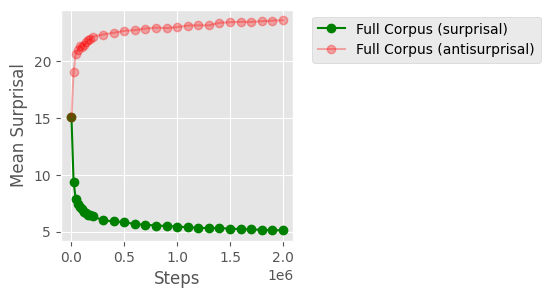

In [11]:
positives = get_avg_df([surprisals], column='MeanSurprisal')
negatives = get_avg_df([surprisals], column='MeanNegSurprisal')

plot_avg_pos_neg(positives, negatives)

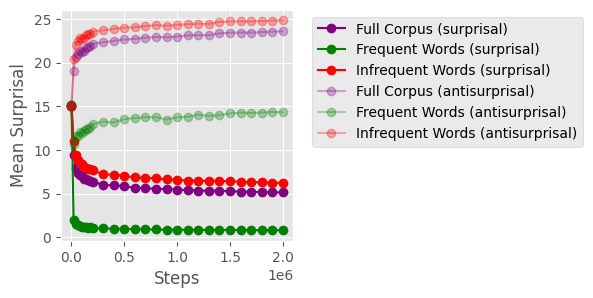

In [13]:
# frequent: all words with at least 512 examples
# infrequent: all words with only 1 example

frequent = surprisals[surprisals['NumExamples'] == 512]
infrequent = surprisals[surprisals['NumExamples'] == 1]

positives = get_avg_df([surprisals, frequent, infrequent], column='MeanSurprisal')
negatives = get_avg_df([surprisals, frequent, infrequent], column='MeanNegSurprisal')

plot_avg_pos_neg(positives, negatives)

In [22]:
surprisal_stats = {
    'Category': ['Full corpus', 'Frequent words', 'Infrequent words'],
    'Min Surprisal': [round(positives[0].MeanSurprisal.min(), 2), round(positives[1].MeanSurprisal.min(), 2), round(positives[2].MeanSurprisal.min(), 2)],
    'Max Surprisal': [round(positives[0].MeanSurprisal.iloc[1:].max(), 2), round(positives[1].MeanSurprisal.iloc[1:].max(), 2), round(positives[2].MeanSurprisal.iloc[1:].max(), 2)],
    'Average Variability': [round(positives[0].Diffs.iloc[2:].mean(), 2), round(positives[1].Diffs.iloc[2:].mean(), 2), round(positives[2].Diffs.iloc[2:].mean(), 2)]
}

pd.DataFrame(surprisal_stats)


,Category,Min Surprisal,Max Surprisal,Average Variability
0,Full corpus,5.13,9.37,-0.16
1,Frequent words,0.80,1.99,-0.04
2,Infrequent words,6.23,11.00,-0.18


In [25]:
antisurprisal_stats = {
    'Category': ['Full corpus', 'Frequent words', 'Infrequent words'],
    'Min Antisurprisal': [round(negatives[0].MeanNegSurprisal.min(), 2), round(negatives[1].MeanNegSurprisal.min(), 2), round(negatives[2].MeanNegSurprisal.min(), 2)],
    'Max Antisurprisal': [round(negatives[0].MeanNegSurprisal.iloc[1:].max(), 2), round(negatives[1].MeanNegSurprisal.iloc[1:].max(), 2), round(negatives[2].MeanNegSurprisal.iloc[1:].max(), 2)],
    'Average Variability': [round(negatives[0].Diffs.iloc[2:].mean(), 2), round(negatives[1].Diffs.iloc[2:].mean(), 2), round(negatives[2].Diffs.iloc[2:].mean(), 2)]
}

pd.DataFrame(antisurprisal_stats)

,Category,Min Antisurprisal,Max Antisurprisal,Average Variability
0,Full corpus,15.06,23.58,0.17
1,Frequent words,10.67,14.33,0.13
2,Infrequent words,15.06,24.84,0.17


### Pearson Correlation

In [2]:
def pearson_correlation(group):
    if len(group) < 2:
        return None
    corr, _ = pearsonr(group['MeanSurprisal'], group['MeanNegSurprisal'])
    return corr

In [3]:
wikitext_surprisals = '../results/shuffled_bert_surprisals.txt'
surprisals = pd.read_csv(wikitext_surprisals, delimiter='\t')

In [4]:
# correlations = surprisals.groupby('Token').apply(pearson_correlation).dropna()    # including the first step
correlations = surprisals[surprisals['Steps'] != 0].groupby('Token').apply(pearson_correlation).dropna()    # excluding the first step
correlations = pd.DataFrame(correlations, columns=['Correlation']).reset_index()
correlations

/var/folders/9z/vb7mydrn6kj_y7zf3cgd_26h0000gn/T/ipykernel_57434/2757183774.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = surprisals[surprisals['Steps'] != 0].groupby('Token').apply(pearson_correlation).dropna()    # excluding the first step


,Token,Correlation
0,a,-0.612520
1,aa,-0.737084
2,abandon,-0.632056
3,abandoned,-0.803427
4,abandoning,-0.695387
...,...,...
9073,zone,-0.844724
9074,zones,-0.752386
9075,zoo,0.315776
9076,zoom,-0.765397


In [5]:
# source: Cohen, J. (1988). Statistical power analysis for the behavioral sciences (2nd ed.). Hillsdale, NJ: Lawrence Erlbaum Associates: 
# bins = [-1, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 1]

# what looks good :P : 
# bins = [-1, -0.7, -0.3, 0.3, 0.7, 1]
# labels = ['Strong Negative', 'Moderate Negative', 'Weak or No Correlation', 'Moderate Positive', 'Strong Positive']

bins = [-1, -0.6, -0.3, -0.1, 0.1, 0.3, 0.6, 1] # personal adaptation of Cohen, J. (1988)
labels = ['Strong Negative', 'Moderate Negative', 'Weak Negative', 'No Correlation', 'Weak Positive', 'Moderate Positive', 'Strong Positive']

correlations['Correlation Strength'] = pd.cut(correlations['Correlation'], bins=bins, labels=labels)
correlations

,Token,Correlation,Correlation Strength
0,a,-0.612520,Strong Negative
1,aa,-0.737084,Strong Negative
2,abandon,-0.632056,Strong Negative
3,abandoned,-0.803427,Strong Negative
4,abandoning,-0.695387,Strong Negative
...,...,...,...
9073,zone,-0.844724,Strong Negative
9074,zones,-0.752386,Strong Negative
9075,zoo,0.315776,Moderate Positive
9076,zoom,-0.765397,Strong Negative


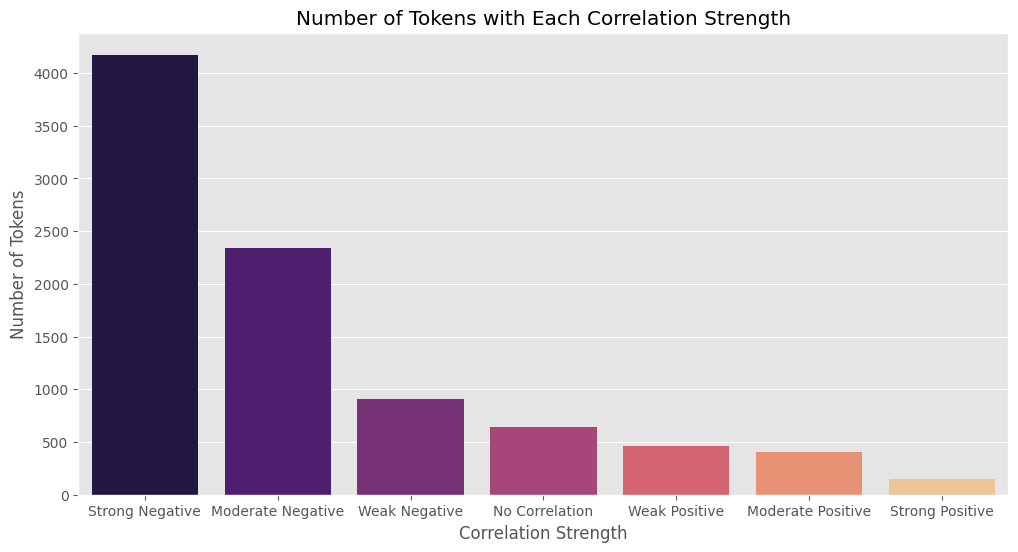

In [6]:
import seaborn as sns

strength_counts = correlations['Correlation Strength'].value_counts().sort_index()

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
sns.barplot(x=strength_counts.index, y=strength_counts.values, hue=strength_counts.index, palette='magma')

plt.ylabel('Number of Tokens')
plt.title('Number of Tokens with Each Correlation Strength')
plt.show()

<Figure size 1200x600 with 0 Axes>

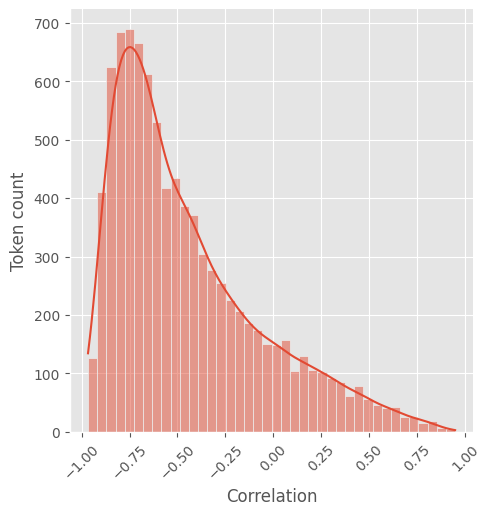

In [7]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
sns.displot(data=correlations, x='Correlation', kde=True)

# plt.title('Token Count Distribution Across Correlation Values.', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Token count')
plt.savefig('../correlation.pdf', format='pdf', bbox_inches='tight')

plt.show()

#### Average frequency in each category

In [41]:
wordbank = pd.read_csv('../data/processed/wikitext_wordbank.tsv', sep='\t')

correlations['Token Counts'] = wordbank[wordbank.token.isin(correlations.Token)].reset_index()['count']
correlations

,Token,Correlation,Correlation Strength,Token Counts
0,a,-0.612520,Strong Negative,4030
1,aa,-0.737084,Strong Negative,16
2,abandon,-0.632056,Strong Negative,1
3,abandoned,-0.803427,Strong Negative,26
4,abandoning,-0.695387,Strong Negative,1
...,...,...,...,...
9073,zone,-0.844724,Strong Negative,21
9074,zones,-0.752386,Strong Negative,6
9075,zoo,0.315776,Moderate Positive,2
9076,zoom,-0.765397,Strong Negative,1


In [45]:
# Average token frequency in each category

correlations.groupby('Correlation Strength', observed=False).agg(Average_Token_Frequency=('Token Counts', 'mean')).reset_index()

,Correlation Strength,Average_Token_Frequency
0,Strong Negative,28.079061
1,Moderate Negative,8.001711
2,Weak Negative,9.294956
3,No Correlation,6.213166
4,Weak Positive,16.767742
5,Moderate Positive,10.785185
6,Strong Positive,8.821918


In [46]:
# Crosstab

def categorize(count):
    if count >= 512:
        return 'frequent'
    elif count == 1:
        return 'infrequent'
    else:
        return 'in between'

correlations['Frequency'] = correlations['Token Counts'].apply(categorize)

pd.crosstab(correlations['Correlation Strength'], correlations['Frequency'])

Frequency,frequent,in between,infrequent
Correlation Strength,,,
Strong Negative,20,3299,855
Moderate Negative,1,1631,706
Weak Negative,1,563,348
No Correlation,0,407,231
Weak Positive,2,254,209
Moderate Positive,1,249,155
Strong Positive,0,92,54


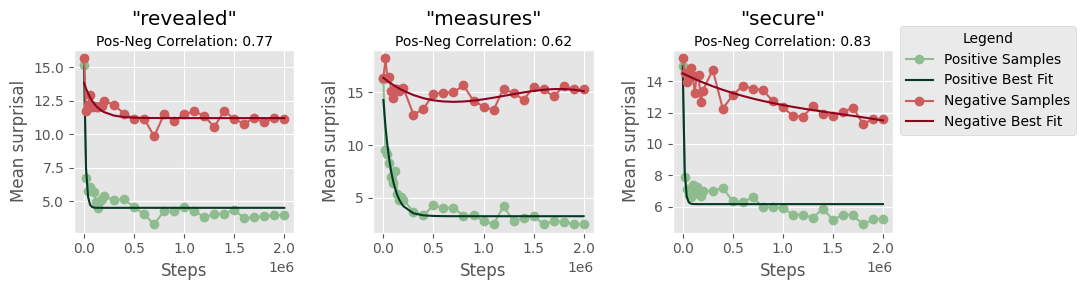

,Token,Correlation,Correlation Strength,Token Counts,Frequency
4945,measures,0.623607,Strong Positive,26,in between
6866,revealed,0.770795,Strong Positive,11,in between
7167,secure,0.828963,Strong Positive,12,in between


In [48]:
tokens_to_inspect = correlations[(correlations['Correlation Strength'] == 'Strong Positive') & (correlations['Frequency'] == 'in between')]
sample = tokens_to_inspect.Token.sample(3)
plot_surprisals(sample, surprisals, neg_samples=True, fit_curve=True, first_step=False)
correlations[correlations['Token'].isin(sample)]

**Observation:**

The results are very different when including and excluding the first step in the correlation calculation.
Many of the words show a strong negative correlation in the first step but positively correlate in subsequent steps and vice versa. 
In order to view the general trend, I decided to exclude the first step from the calculations. 

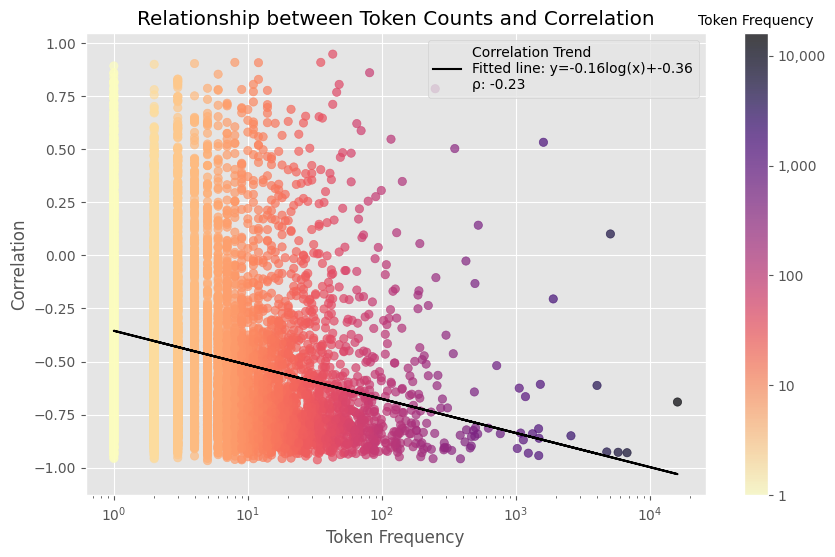

In [49]:
# Plotting the relationship between token counts and correlation strength

from scipy.stats import linregress

x = correlations['Token Counts']
y = correlations['Correlation']

slope, intercept, r, p, stderr = linregress(np.log10(x), y)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=np.log10(x), cmap='magma_r', alpha=0.7)

plt.plot(x, slope * np.log10(x) + intercept, color='black', 
         label=f'Correlation Trend\nFitted line: y={slope:.2f}log(x)+{intercept:.2f}\nρ: {r:.2f}')
plt.legend()

plt.xlabel('Token Frequency')
plt.ylabel('Correlation')
plt.title('Relationship between Token Counts and Correlation')
plt.xscale('log')

cbar = plt.colorbar(scatter)
cbar.ax.set_title('Token Frequency', fontsize=10, loc='center')

log_ticks = np.log10([1, 10, 100, 1000, 10000])
cbar.set_ticks(log_ticks)
cbar.set_ticklabels([f"{int(10**i):,}" for i in log_ticks])

plt.grid(True)
plt.show()

**Observation:**

There is a weak negative relationship ($ρ = -0.23$) between token frequency and surprisal correlation

In [50]:
positive_corr = correlations[correlations['Correlation Strength'].isin(['Weak Positive', 'Moderate Positive', 'Strong Positive'])].reset_index(drop=True)

In [51]:
# Number of positive vs. negative trends in words with positive correlation

def calculate_trend(group):
    slope, _, _, _, _ = linregress(group['Steps'], group['MeanSurprisal'])
    return 'decreasing' if slope < 0 else 'increasing'

positive_corr['Surprisal Trend'] = surprisals[(surprisals.Token.isin(positive_corr.Token)) & (surprisals.Steps != 0)]\
    .groupby('Token')[['Steps', 'MeanSurprisal']]\
        .apply(lambda group: calculate_trend(group))\
            .reset_index(level=0, drop=True)

positive_corr['Surprisal Trend'].value_counts()


Surprisal Trend
decreasing    668
increasing    348
Name: count, dtype: int64

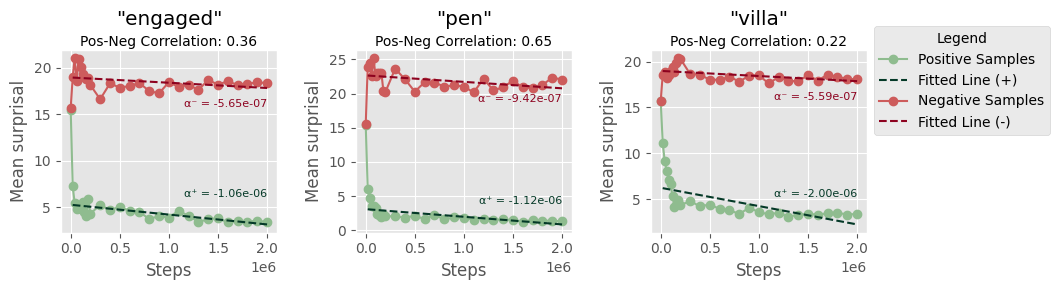

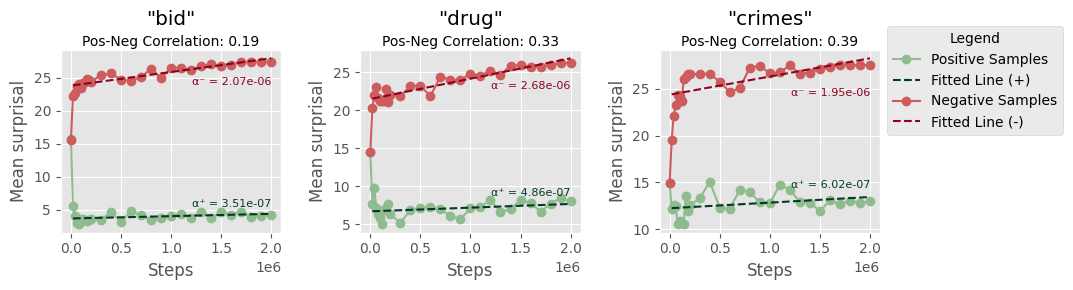

In [54]:
dec_trend_samples = positive_corr[positive_corr['Surprisal Trend'] == 'decreasing'].Token.sample(3)
inc_trend_samples = positive_corr[positive_corr['Surprisal Trend'] == 'increasing'].Token.sample(3)
plot_surprisals(dec_trend_samples, surprisals, neg_samples=True, fit_line=True, first_step=False)
plot_surprisals(inc_trend_samples, surprisals, neg_samples=True, fit_line=True, first_step=False)